训练 VQ-VAE 以进行图像重建和生成码本采样
- 论文：[Neural Discrete Representation Learning]([1711.00937.pdf (arxiv.org)](https://arxiv.org/pdf/1711.00937.pdf))
- 代码：https://keras.io/examples/generative/vq_vae/

![VQVAE](./../assert/VQVAE.png)

In [23]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers
import tensorflow_probability as tfp
import tensorflow as tf

In [24]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        # 形状：(batch_size,)
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        # 注意这里对self.embeddings，形状变成了：(num_embeddings,embedding_dim)
        # quantized形状：(batch_size,embedding_dim),代表每张图片潜在向量在self.num_embeddings里一个最相似的向量
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        #================================================================================
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    #从self.embeddings里计算L2-normalized distance，实际计算带上平方
    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        # flattened_inputs形状：(batch_size,embedding_dim)
        # self.embeddings形状：(embedding_dim, num_embeddings)
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        # 形状：(batch_size,)
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [25]:
#形状：(batch,*,*,latent_dim)
def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [26]:
def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(28, 28, 1))
    #encoder_outputs形状：(batch,*,*,latent_dim)
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 16)          19856     
                                                                 
 vector_quantizer (VectorQu  (None, 7, 7, 16)          1024      
 antizer)                                                        
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         28033     
                                                                 
Total params: 48913 (191.07 KB)
Trainable params: 48913 (191.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

### MNIST数据集

In [28]:
import os
download_path = os.path.join(os.getcwd(), './../data/keras_mnist_datasets')
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data(path=download_path)

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

### 训练

In [29]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)

# 训练之前，输出embeddings
ini_embeddings = vqvae_trainer.vqvae.get_layer("vector_quantizer").embeddings
print('训练之前，输出embeddings:',ini_embeddings)

print('==================encoder和decoder===============================')
ini_encoder_w = vqvae_trainer.vqvae.get_layer("encoder").layers[1].get_weights()[0]
print(ini_encoder_w)
print(ini_encoder_w.shape)

ini_decoder_w = vqvae_trainer.vqvae.get_layer("decoder").layers[1].get_weights()[0]
print(ini_decoder_w)
print(ini_decoder_w.shape)

训练之前，输出embeddings: <tf.Variable 'embeddings_vqvae:0' shape=(16, 128) dtype=float32, numpy=
array([[ 0.03649485, -0.04753878,  0.02308801, ..., -0.0037195 ,
         0.04924415,  0.02109522],
       [ 0.02947006, -0.03414862,  0.00909851, ..., -0.0273054 ,
        -0.00467195,  0.04574228],
       [ 0.02568242,  0.02776284, -0.01097304, ...,  0.02410891,
        -0.00803997,  0.04512575],
       ...,
       [ 0.0257211 ,  0.04348889,  0.03021726, ..., -0.02683233,
         0.04385756,  0.00789311],
       [ 0.01896131,  0.00437589,  0.00093884, ...,  0.03824203,
         0.02487738, -0.00862554],
       [-0.00352681,  0.0462063 , -0.0293408 , ...,  0.00342987,
         0.00240717,  0.03683826]], dtype=float32)>
==================encoder和decoder===============================
[[[[ 3.30367088e-02 -9.29370522e-03  4.65607345e-02 -1.21379346e-01
    -1.03732988e-01  1.20723233e-01 -9.98718962e-02  7.99753219e-02
     1.35034621e-02 -1.66654587e-03  8.43759924e-02  1.31378785e-01
    -9.4282

In [30]:
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(x_train_scaled, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 8s 15ms/step - loss: 2.8369 - reconstruction_loss: 0.3741 - vqvae_loss: 2.1166
Epoch 2/30
469/469 [==============================] - 7s 15ms/step - loss: 2.0065 - reconstruction_loss: 0.1545 - vqvae_loss: 1.8425
Epoch 3/30
469/469 [==============================] - 7s 15ms/step - loss: 0.8741 - reconstruction_loss: 0.1254 - vqvae_loss: 0.7430
Epoch 4/30
469/469 [==============================] - 7s 15ms/step - loss: 0.5712 - reconstruction_loss: 0.1047 - vqvae_loss: 0.4623
Epoch 5/30
469/469 [==============================] - 7s 15ms/step - loss: 0.4391 - reconstruction_loss: 0.0905 - vqvae_loss: 0.3458
Epoch 6/30
469/469 [==============================] - 7s 15ms/step - loss: 0.3688 - reconstruction_loss: 0.0807 - vqvae_loss: 0.2858
Epoch 7/30
469/469 [==============================] - 7s 15ms/step - loss: 0.3172 - reconstruction_loss: 0.0737 - vqvae_loss: 0.2421
Epoch 8/30
469/469 [==============================] - 7s 15ms/step - 

In [31]:
# 训练后，输出embeddings
train_embeddings = vqvae_trainer.vqvae.get_layer("vector_quantizer").embeddings
print('训练之前，输出embeddings:',ini_embeddings)
print('训练后，输出embeddings:',train_embeddings)

print(ini_embeddings == train_embeddings)
threshold = 1e-8
weights_equal = np.all(np.abs(ini_embeddings - train_embeddings) < threshold)
print("权重是否相等：", weights_equal)

print('========================encoder和decoder========================')

train_encoder = vqvae_trainer.vqvae.get_layer("encoder")
train_decoder = vqvae_trainer.vqvae.get_layer("decoder")

train_encoder_w = train_encoder.layers[1].get_weights()[0]
train_decoder_w = train_decoder.layers[1].get_weights()[0]
print(train_encoder_w.shape)
print(train_decoder_w.shape)

weights_equal = np.all(np.abs(ini_encoder_w - train_encoder_w) < threshold)
print("权重是否相等：", weights_equal)

weights_equal = np.all(np.abs(ini_decoder_w - train_decoder_w) < threshold)
print("权重是否相等：", weights_equal)


训练之前，输出embeddings: <tf.Variable 'embeddings_vqvae:0' shape=(16, 128) dtype=float32, numpy=
array([[ 2.7037337e-02, -1.4408082e-01,  2.5033810e+00, ...,
        -1.1627554e-02,  4.9244154e-02, -9.1241103e-01],
       [ 3.5890561e-02,  1.0881172e+00,  6.7661986e-02, ...,
        -2.2563541e-02, -4.6719536e-03,  1.5314993e+00],
       [ 3.4910690e-02, -5.2389634e-01,  1.0847833e+00, ...,
         3.3442795e-02, -8.0399737e-03, -9.9638820e-01],
       ...,
       [ 2.5135819e-02, -1.5692705e+00,  1.2167227e+00, ...,
        -1.8085508e-02,  4.3857563e-02,  3.9160469e-01],
       [ 2.4594393e-02, -2.0831475e+00, -1.8719444e+00, ...,
         3.8097113e-02,  2.4877381e-02, -1.8011544e+00],
       [-8.3493888e-03, -2.0972769e+00,  4.8329890e-01, ...,
         8.0781216e-03,  2.4071708e-03,  3.7881999e+00]], dtype=float32)>
训练后，输出embeddings: <tf.Variable 'embeddings_vqvae:0' shape=(16, 128) dtype=float32, numpy=
array([[ 2.7037337e-02, -1.4408082e-01,  2.5033810e+00, ...,
        -1.1627554e-0

### 重建图像

1/1 [==============================] - 0s 117ms/step


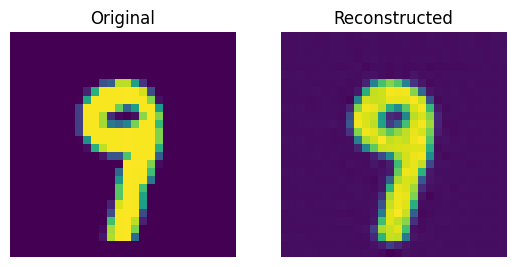

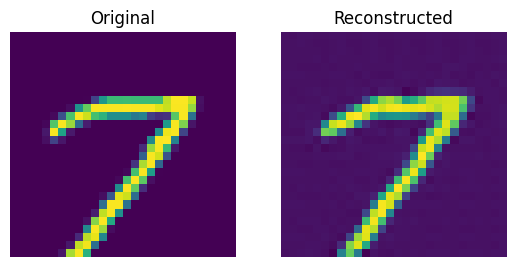

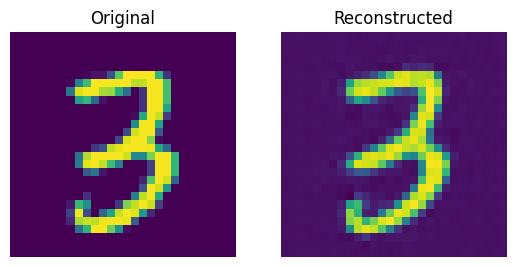

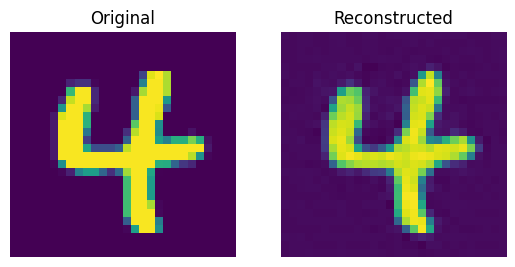

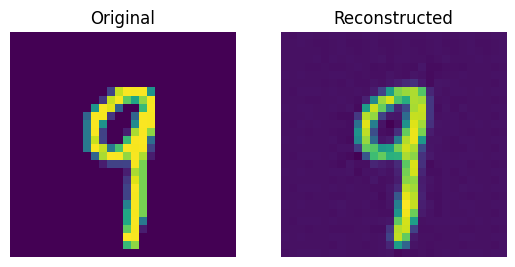

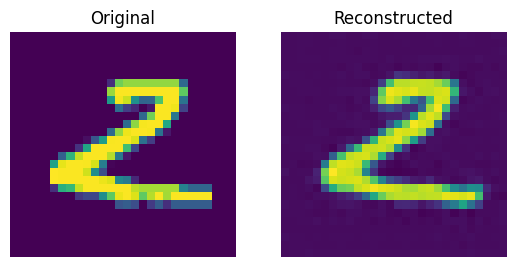

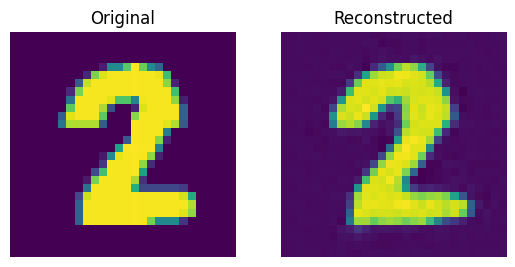

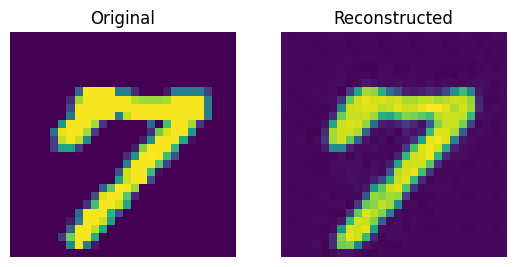

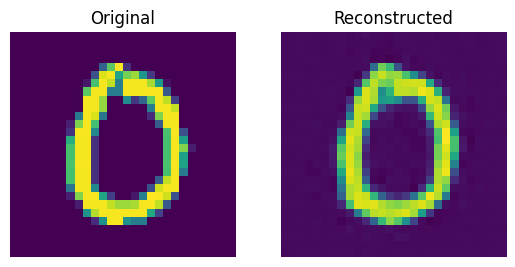

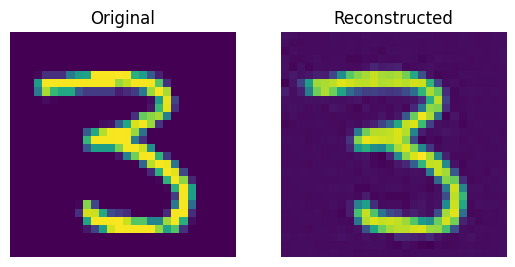

In [32]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)

#### 可视化discrete codes
- discrete codes能够从数据集中捕获一些规律性

1/1 [==============================] - 0s 37ms/step


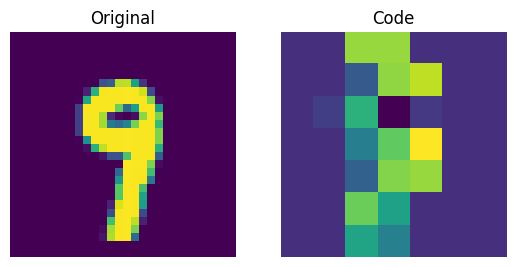

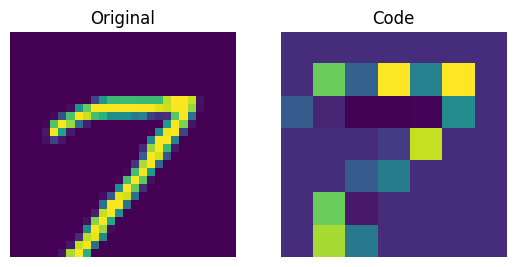

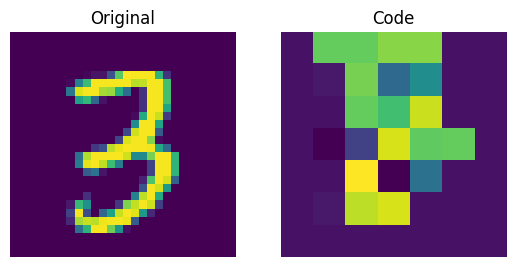

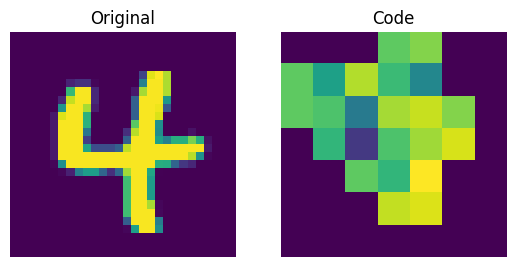

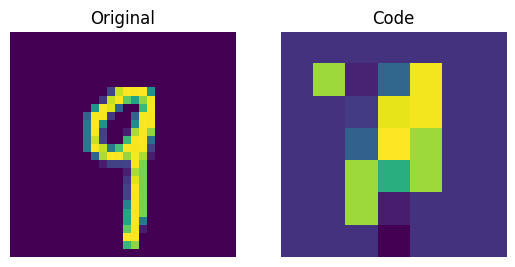

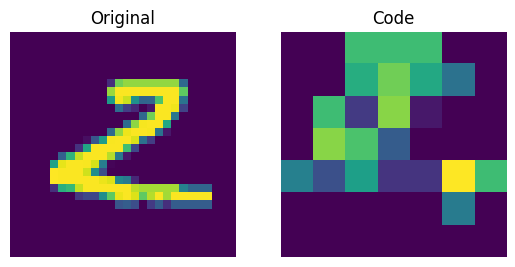

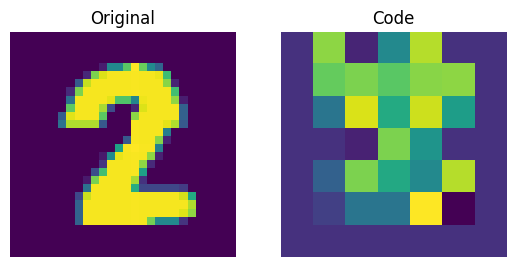

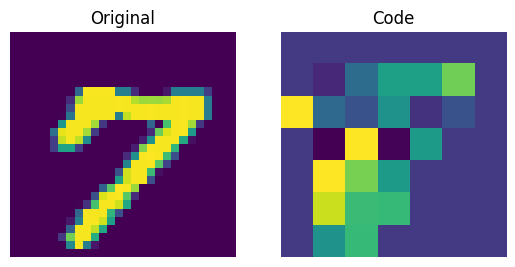

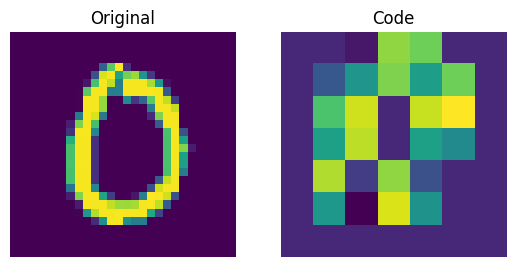

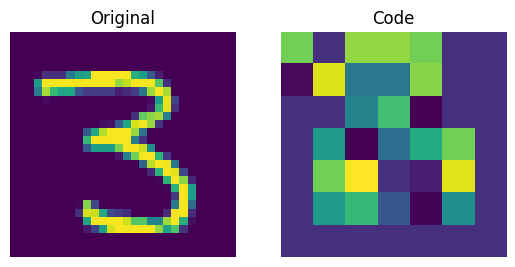

In [33]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()

### 如何从这个codebook中采样来创建新颖的图像

In [34]:
num_residual_blocks = 2
num_pixelcnn_layers = 2
pixelcnn_input_shape = encoded_outputs.shape[1:-1]
print(f"Input shape of the PixelCNN: {pixelcnn_input_shape}")

Input shape of the PixelCNN: (7, 7)


In [35]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
# 带掩码的卷积神经网络
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super().__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])

# 7*7
pixelcnn_inputs = keras.Input(shape=pixelcnn_input_shape, dtype=tf.int32)
ohe = tf.one_hot(pixelcnn_inputs, vqvae_trainer.num_embeddings)
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(ohe)

for _ in range(num_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(num_pixelcnn_layers):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(
    filters=vqvae_trainer.num_embeddings, kernel_size=1, strides=1, padding="valid"
)(x)

pixel_cnn = keras.Model(pixelcnn_inputs, out, name="pixel_cnn")
pixel_cnn.summary()

Model: "pixel_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 7, 7)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, 7, 7, 128)         0         
                                                                 
 pixel_conv_layer (PixelCon  (None, 7, 7, 128)         802944    
 vLayer)                                                         
                                                                 
 residual_block (ResidualBl  (None, 7, 7, 128)         98624     
 ock)                                                            
                                                                 
 residual_block_1 (Residual  (None, 7, 7, 128)         98624     
 Block)                                                          
                                                         

In [36]:
# Generate the codebook indices.
# (image_num,7,7,latent_dim)
encoded_outputs = encoder.predict(x_train_scaled)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
# (image_num*7*7,)
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
# (image_num,7,7)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
print(f"Shape of the training data for PixelCNN: {codebook_indices.shape}")

1875/1875 [==============================] - 2s 975us/step
Shape of the training data for PixelCNN: (60000, 7, 7)


In [37]:
pixel_cnn.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
pixel_cnn.fit(
    x=codebook_indices,
    y=codebook_indices,
    batch_size=128,
    epochs=30,
    validation_split=0.1,
)

Epoch 1/30

422/422 [==============================] - 21s 46ms/step - loss: 1.8961 - accuracy: 0.5975 - val_loss: 1.3276 - val_accuracy: 0.6251
Epoch 2/30
422/422 [==============================] - 19s 44ms/step - loss: 1.2454 - accuracy: 0.6381 - val_loss: 1.2090 - val_accuracy: 0.6429
Epoch 3/30
422/422 [==============================] - 19s 44ms/step - loss: 1.1740 - accuracy: 0.6500 - val_loss: 1.1684 - val_accuracy: 0.6498
Epoch 4/30
422/422 [==============================] - 19s 44ms/step - loss: 1.1368 - accuracy: 0.6560 - val_loss: 1.1462 - val_accuracy: 0.6533
Epoch 5/30
422/422 [==============================] - 19s 44ms/step - loss: 1.1117 - accuracy: 0.6609 - val_loss: 1.1217 - val_accuracy: 0.6583
Epoch 6/30
422/422 [==============================] - 19s 44ms/step - loss: 1.0921 - accuracy: 0.6646 - val_loss: 1.1124 - val_accuracy: 0.6600
Epoch 7/30
422/422 [==============================] - 19s 44ms/step - loss: 1.0772 - accuracy: 0.6677 - val_loss: 1.1029 - val_accuracy

In [38]:
inputs = layers.Input(shape=pixel_cnn.input_shape[1:])
outputs = pixel_cnn(inputs, training=False)
categorical_layer = tfp.layers.DistributionLambda(tfp.distributions.Categorical)
outputs = categorical_layer(outputs)
sampler = keras.Model(inputs, outputs)

In [39]:
# Create an empty array of priors.
batch = 10
priors = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols = priors.shape

# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in range(rows):
    for col in range(cols):
        # Feed the whole array and retrieving the pixel value probabilities for the next
        # pixel.
        probs = sampler.predict(priors)
        # Use the probabilities to pick pixel values and append the values to the priors.
        priors[:, row, col] = probs[:, row, col]

print(f"Prior shape: {priors.shape}")

1/1 [==============================] - 0s 17ms/step
Prior shape: (10, 7, 7)


1/1 [==============================] - 0s 51ms/step


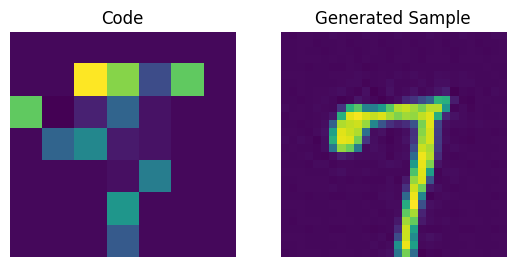

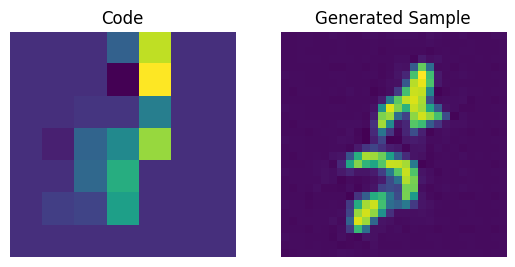

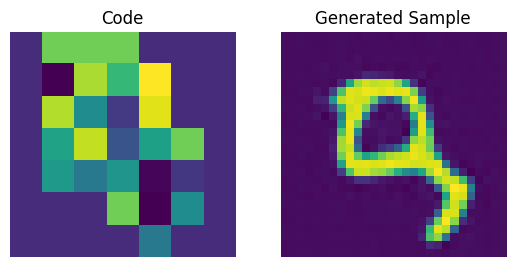

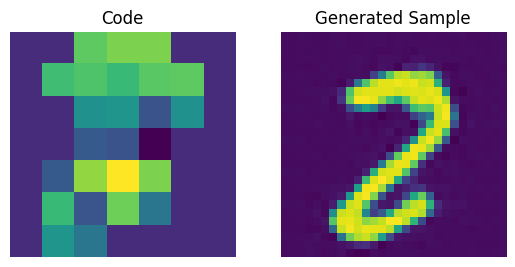

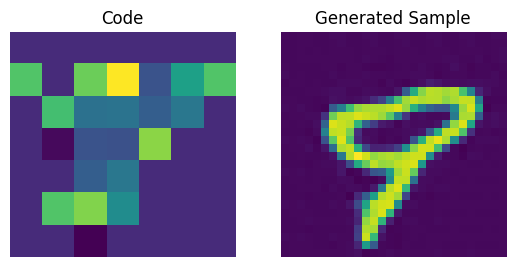

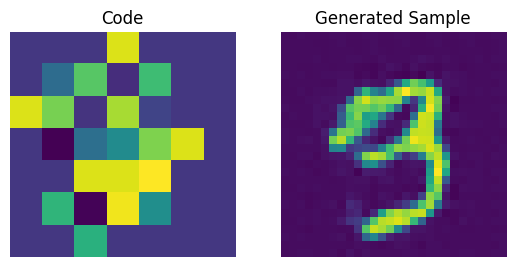

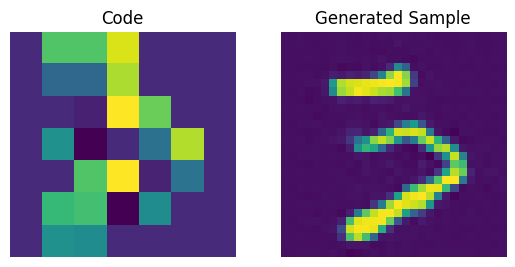

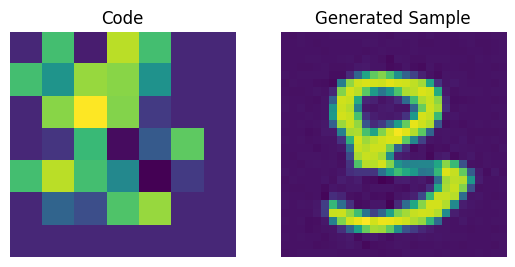

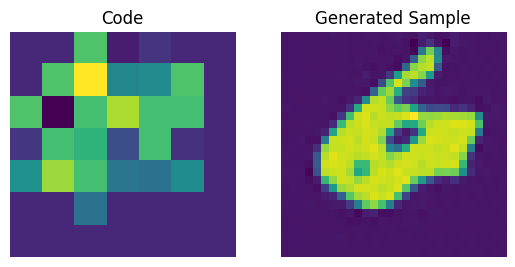

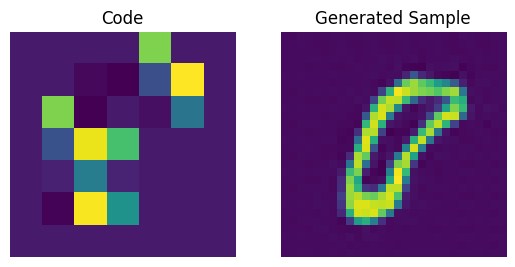

In [40]:
# Perform an embedding lookup.
# code books
pretrained_embeddings = quantizer.embeddings

# priors重建的code books里的索引
priors_ohe = tf.one_hot(priors.astype("int32"), vqvae_trainer.num_embeddings).numpy()

# 从code books里拿向量
quantized = tf.matmul(
    priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
)
quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))

# Generate novel images.
decoder = vqvae_trainer.vqvae.get_layer("decoder")
generated_samples = decoder.predict(quantized)

for i in range(batch):
    plt.subplot(1, 2, 1)
    plt.imshow(priors[i])
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_samples[i].squeeze() + 0.5)
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()